# 🔗 Proyecto de Detección de Fraude - Google Colab

In [1]:
# ✅ Clonar el repositorio (asegúrate de que sea público)
!git clone https://github.com/solivare/DeepNeuralNetworkUSS.git
%cd DeepNeuralNetworkUSS/Examples/Fraud


Cloning into 'DeepNeuralNetworkUSS'...
remote: Enumerating objects: 1780, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1780 (delta 48), reused 93 (delta 41), pack-reused 1674 (from 1)
Receiving objects: 100% (1780/1780), 70.35 MiB | 19.19 MiB/s, done.
Resolving deltas: 100% (266/266), done.
/content/DeepNeuralNetworkUSS/Examples/Fraud


In [15]:
# ✅ Instalar librerías necesarias
!pip install -r requirements.txt


In [3]:
# ✅ Descargar el dataset desde Google Drive (archivo ya compartido públicamente)
!pip install -q gdown
!mkdir -p data
!gdown --id 1KVCoiYWN9mtDnQhhqDNeEpDr9Az9jKVa -O data/creditcard.csv


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1KVCoiYWN9mtDnQhhqDNeEpDr9Az9jKVa
From (redirected): https://drive.google.com/uc?id=1KVCoiYWN9mtDnQhhqDNeEpDr9Az9jKVa&confirm=t&uuid=bc7c8c15-1aa1-44a6-a56b-a060271a8b5a
To: /content/DeepNeuralNetworkUSS/Examples/Fraud/data/creditcard.csv
100% 151M/151M [00:01<00:00, 125MB/s]


In [4]:
# ✅ Procesar los datos
!python src/preprocess.py


Dataset original: 284807 filas, 31 columnas
✅ Archivos completos guardados (train_full, val, test)


In [5]:
# ✅ Entrenar modelo NN
!python -c "import src.train as train; train.train()"

2025-08-05 03:22:12.462313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754364132.498788    1390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754364132.509580    1390 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 03:22:12.541601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 03:22:19.362847: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting becau

In [6]:
# ✅ Carga de configuracion
import sys, os
sys.path.append("src")

import train
import evaluate
from utils import *

import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Cargar configuración y datos
config = train.load_config()
train_path = get_training_data_path(config)
X_train, y_train = train.load_data(train_path, config["base_dir"])
X_test, y_test = train.load_data(config["paths"]["test"], config["base_dir"])

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# ✅ Carga de modelo NN y entrenamiento modelo Regresion Logistica

# Red Neuronal
model_path = os.path.join(config["base_dir"], "models", "model.keras")
nn_model = load_model(model_path)
y_prob_nn = nn_model.predict(X_test_scaled).flatten()
y_prob_train_nn = nn_model.predict(X_train_scaled).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = (y_prob_lr > 0.5).astype(int)

# Grafico Loss Function y Precision para la NN
plot_training(history)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


NameError: name 'history' is not defined

In [9]:
# ✅ Evaluación: generación de métricas y visualizaciones

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print("🔎 Regressión Logística")
print(classification_report(y_test, y_pred_lr, target_names=["No Fraude", "Fraude"]))
print("AUC:", roc_auc_score(y_test, y_prob_lr))

print("\n🔎 Red Neuronal")
print(classification_report(y_test, y_pred_nn, target_names=["No Fraude", "Fraude"]))
print("AUC:", roc_auc_score(y_test, y_prob_nn))

🔎 Regressión Logística
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     42648
      Fraude       0.92      0.64      0.75        74

    accuracy                           1.00     42722
   macro avg       0.96      0.82      0.88     42722
weighted avg       1.00      1.00      1.00     42722

AUC: 0.9564594138313891

🔎 Red Neuronal
              precision    recall  f1-score   support

   No Fraude       1.00      0.99      0.99     42648
      Fraude       0.10      0.88      0.18        74

    accuracy                           0.99     42722
   macro avg       0.55      0.93      0.59     42722
weighted avg       1.00      0.99      0.99     42722

AUC: 0.980772838116676


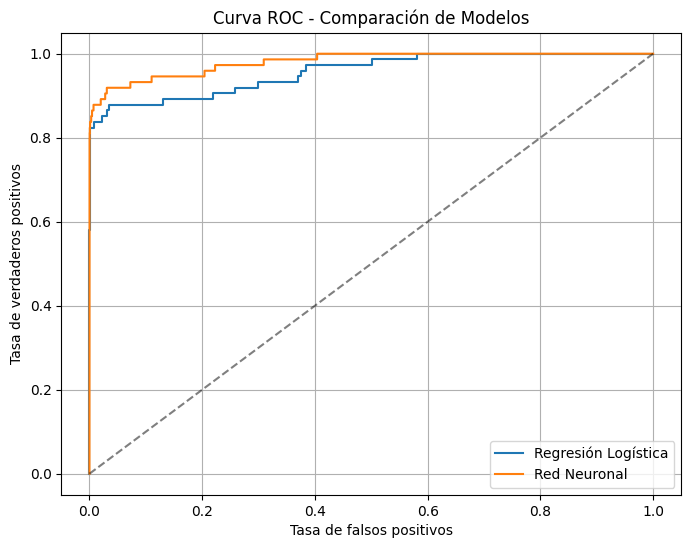

In [10]:
# ✅ Comparar curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label="Regresión Logística")
plt.plot(fpr_nn, tpr_nn, label="Red Neuronal")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC - Comparación de Modelos")
plt.legend()
plt.grid()
plt.show()

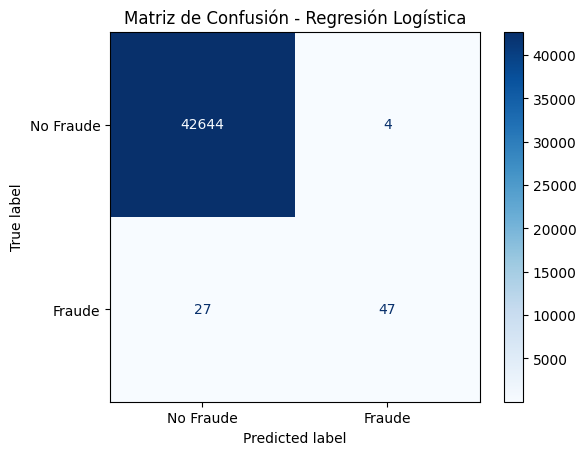

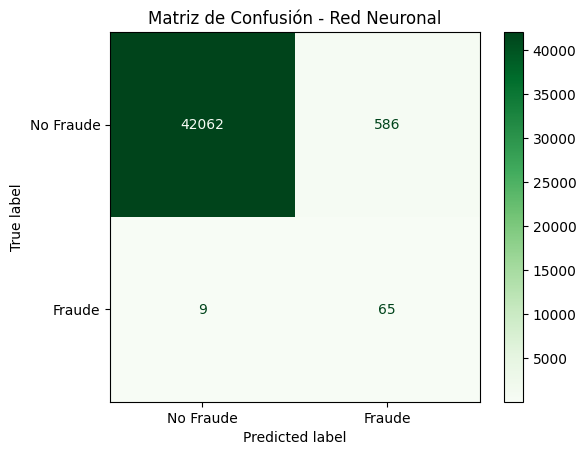

,Accuracy,Precision,Recall,F1-score,AUC
Modelo,,,,,
Regresión Logística,0.9993,0.9216,0.6351,0.7520,0.9565
Red Neuronal,0.9861,0.0998,0.8784,0.1793,0.9808


In [11]:
# ✅  Metricas de modelos

# Matrices de confusión
plot_confusion_matrix(y_test, y_pred_lr, model_name="Regresión Logística", cmap="Blues")
plot_confusion_matrix(y_test, y_pred_nn, model_name="Red Neuronal", cmap="Greens")

# Tabla de métricas
df_metrics = get_classification_metrics_df(
    y_test, y_pred_lr, y_prob_lr,
    y_test, y_pred_nn, y_prob_nn
)
display(df_metrics)

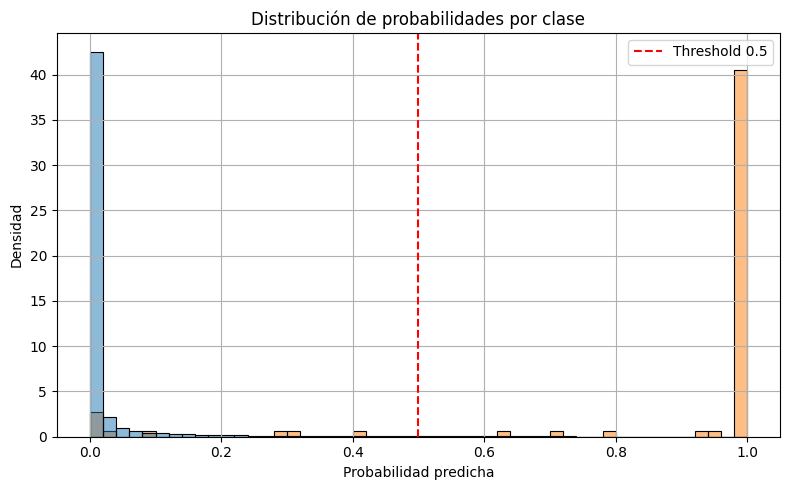

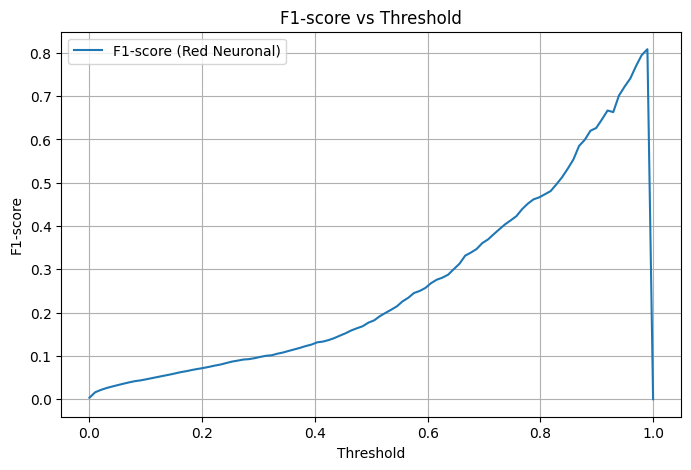

In [12]:
# ✅ Distribución de predicciones para NN
plot_prediction_distribution(y_test, y_prob_nn)
plot_f1_vs_threshold(y_test, y_prob_nn, modelo="Red Neuronal")

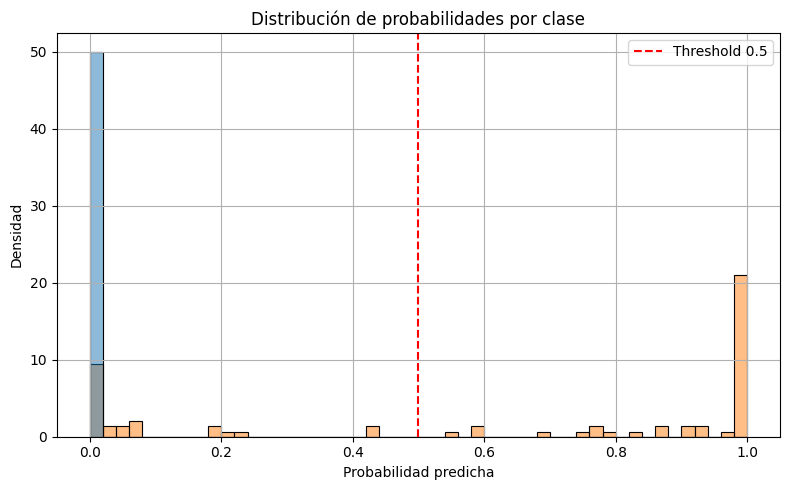

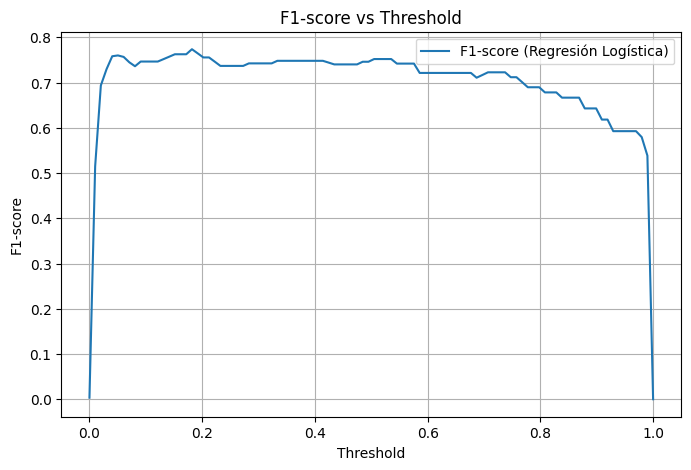

In [13]:
# ✅ Distribución de predicciones para Regresión Logística
plot_prediction_distribution(y_test, y_prob_lr)
plot_f1_vs_threshold(y_test, y_prob_lr, modelo="Regresión Logística")

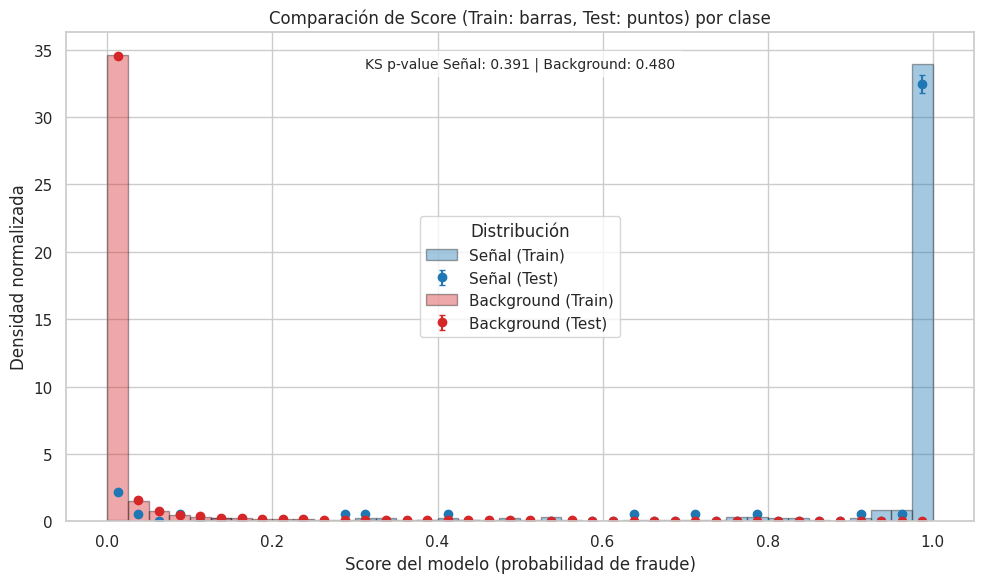

In [14]:
# ✅ Evaluación de sobreajuste en la red neuronal
plot_ks_overtraining(y_train, y_prob_train_nn, y_test, y_prob_nn)